In [91]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from inmoose import limma
import plotly.express as px
#Find the utils Directory
sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv
from src.utils.Preprocessing import elimnation_zeros, total_type_len_type_cancer
from src.utils.plots import PCA_4_scatter_matrix_log2, box_plot

%matplotlib inline

<font size="4">Get the DataFrame from the clinical Data</font>

In [3]:
df_clincal_data = pd.read_csv("../../data/raw/brca_tcga_pub2015_clinical_data.tsv", sep='\t')
list_df = total_type_len_type_cancer(df_clincal_data)
df_clincal_data["Tumor-Cancer"] = list_df

Luminal A: 330 - Total(%): 0.40
Luminal B: 81 - Total(%):0.10
HER2-enriched: 23 - Total(%):0.03
TNBC: 85 - Total(%)0.10 
UNK: 299 - Total(%) 0.37


In [4]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

<font size="4">Get the DataFrame from the mRNA-Seq Data</font>

In [5]:
df_mRNA = pd.read_csv("../../data/raw/data_mrna_seq_v2_rsem.txt", header=None)
df_mRNA_transformed = TextToCsv("../../data/raw/data_mrna_seq_v2_rsem.txt")

Shape of the CSV: (20440, 819)


<font size="4">Transform the mRNA-Seq for merging the two DataFrames</font>

In [6]:
df_mRNA_transformed = df_mRNA_transformed.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"], axis=0)
df_mrna = df_mRNA_transformed.T.reset_index()
df_mRNA_final = df_mrna.rename(columns={"index":"Sample ID"})

<font size="4">Merging the clinical DataSet and mRNA-Seq</font>

In [7]:
df_merged = pd.merge(df_mRNA_final, df_clincal_data, right_on="Sample ID", left_on="Sample ID")

<font size="4">Getting the information of the columns of the mRNA-Seq and classes</font>

In [8]:
comparation_df = df_merged.loc[
    df_merged["Tumor-Cancer"].isin(["Luminal A", "Luminal B", "TNBC", "HER2-enriched"]),
    ["Tumor-Cancer"] + list(df_merged.columns[1:20441])
]
comparation_df["Tumor-Cancer"].unique()

array(['Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'], dtype=object)

In [9]:
zeros_reduced_df = elimnation_zeros(comparation_df)

Max of zeros per row in the dataset: 519
Avg of zeros per row in the dataset: 74.00381604696673
Median of zeros per row in the dataset: 0.0
Min of zeros per row in the dataset: 0
After the 0 elimination: 16270


In [10]:
print(f"Samples: {zeros_reduced_df.shape[0]}, Genes: {zeros_reduced_df.shape[1]}")

Samples: 519, Genes: 16270


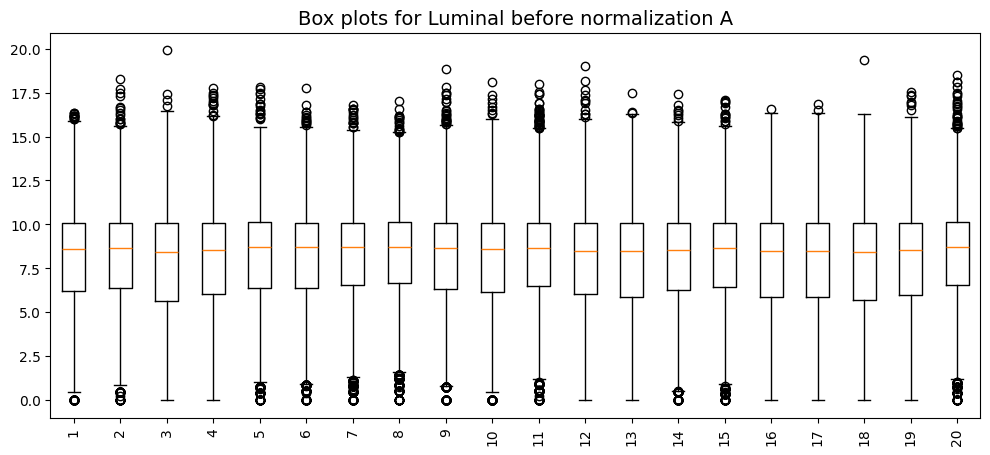

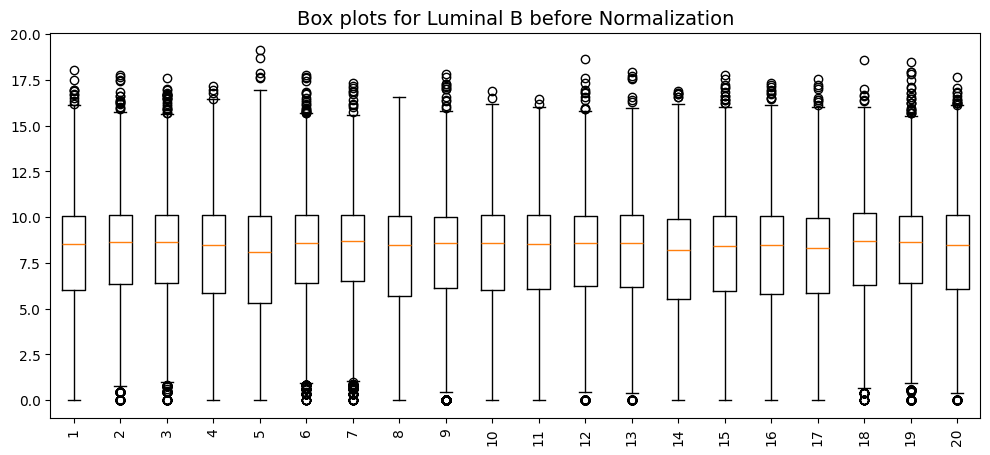

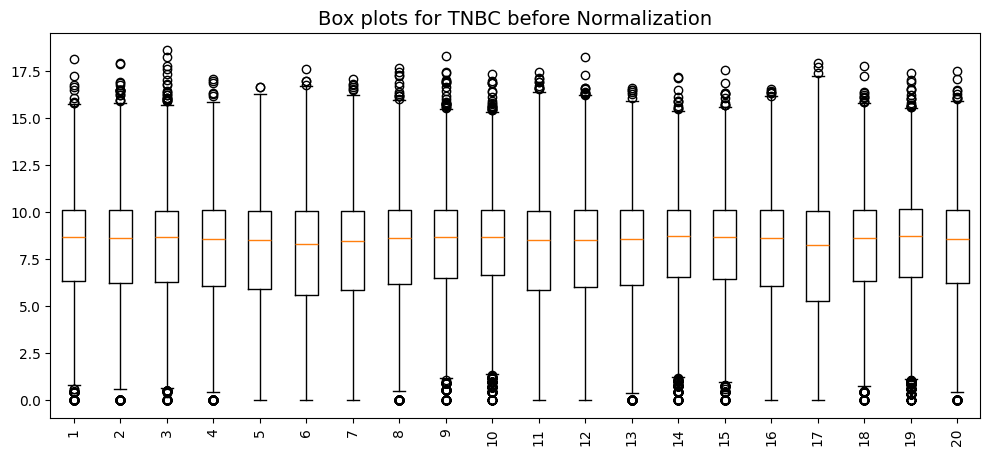

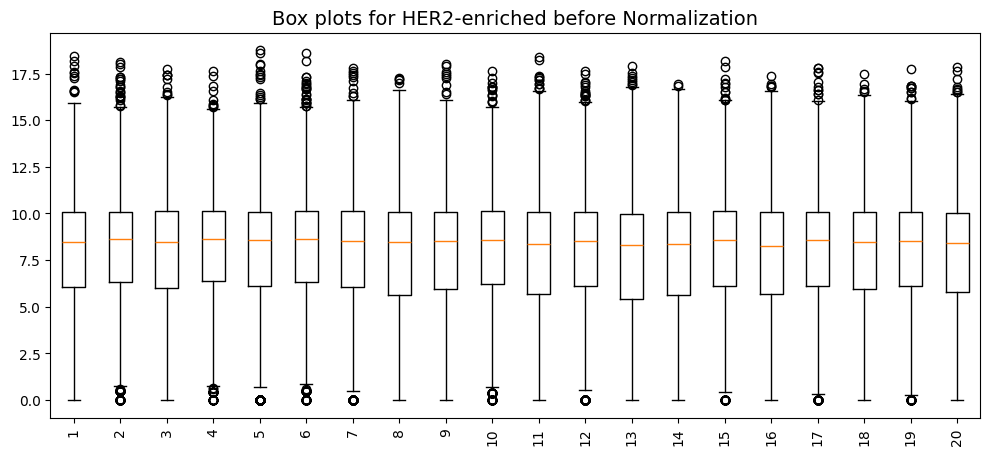

In [25]:
box_plot(df=zeros_reduced_df, title="Box plots for Luminal before normalization A", type_cancer="Luminal A")
box_plot(df=zeros_reduced_df, title="Box plots for Luminal B before Normalization", type_cancer="Luminal B")
box_plot(df=zeros_reduced_df, title="Box plots for TNBC before Normalization", type_cancer="TNBC")
box_plot(df=zeros_reduced_df, title="Box plots for HER2-enriched before Normalization", type_cancer="HER2-enriched")

In [26]:
PCA_4_scatter_matrix_log2(df=zeros_reduced_df, cancer_types=["Luminal A", "Luminal B", "TNBC", "HER2-enriched"])

<font size="4">Transformation of Log2 of the data</font>

In [11]:
metadata = pd.DataFrame(zeros_reduced_df["Tumor-Cancer"], index=zeros_reduced_df.index)
metadata.columns = ["Tumor_Cancer"]
counts_data = zeros_reduced_df.drop(columns=["Tumor-Cancer"])

counts_data = np.log2(counts_data + 1)
expr = counts_data.T
print(f"Genes {counts_data.shape[0]}, Samples {counts_data.shape[1]}")
print("metadata rows:", metadata.shape[0])
print("counts_data rows:", counts_data.shape[0])
print("counts_data cols:", counts_data.shape[1])
(expr.columns == metadata.index).all()

Genes 519, Samples 16269
metadata rows: 519
counts_data rows: 519
counts_data cols: 16269


np.True_

In [28]:
metadata_aligned = metadata.loc[expr.columns].copy()
dummies = pd.get_dummies(metadata_aligned["Tumor_Cancer"]).astype(float)
design = dummies
print(design.shape)
print(design.columns)

design

(519, 4)
Index(['HER2-enriched', 'Luminal A', 'Luminal B', 'TNBC'], dtype='object')


,HER2-enriched,Luminal A,Luminal B,TNBC
2,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,1.0,0.0
10,0.0,0.0,0.0,1.0
...,...,...,...,...
812,0.0,1.0,0.0,0.0
813,0.0,1.0,0.0,0.0
814,0.0,0.0,0.0,1.0
815,0.0,1.0,0.0,0.0


<font size="4">Limma functions</font>

In [89]:
#This is for fitting the models
limma_fit_models = limma.lmFit(obj=expr, design=design)

#Emperical moderate Bayes (eBayes)
limma_fit_models = limma.eBayes(limma_fit_models)

#Obtain the table of Results
results = limma.topTable(limma_fit_models, number=np.inf)


#Transform to pandas dataframe
results_df = pd.DataFrame(results)
results_df

,column0,column1,column2,column3,AveExpr,F,pvalue,adj_pvalue
10188,2.741544,3.980984,3.308898,2.849358,3.635831,859.160812,0.000000e+00,0.000000e+00
10189,11.317054,12.082887,11.655010,10.554771,11.731901,30101.080167,0.000000e+00,0.000000e+00
56,9.727526,11.141363,10.757791,9.867774,10.810260,16125.787712,0.000000e+00,0.000000e+00
10190,7.473603,7.675518,7.483152,7.561101,7.617808,20132.518332,0.000000e+00,0.000000e+00
58,7.258109,8.073024,7.716143,7.730618,7.925134,6153.749519,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
5630,2.679652,1.837475,2.586356,1.636177,1.958707,131.465933,1.704643e-112,1.705062e-112
4537,1.177123,3.849702,3.187019,1.143594,3.184643,126.226241,5.823399e-108,5.824473e-108
16977,1.054401,3.402690,2.169965,1.787912,2.841770,125.603897,2.011869e-107,2.012117e-107
13607,2.598983,1.471813,1.876862,2.484594,1.750850,110.503922,2.311433e-94,2.311576e-94


<font size="4">PCA</font>

In [101]:
X = results_df[["column0", "column1", "column2", "column3"]].T
y = np.array(["HER2-enriched", "Luminal A", "Luminal B", "TNBC"])


X_scaled = StandardScaler().fit_transform(X)


pca = PCA(n_components=2, random_state=0)
components = pca.fit_transform(X_scaled)


df_plot = pd.DataFrame(components, columns=["PC1", "PC2"])
df_plot["Subtype"] = y


fig = px.scatter(
        df_plot,
        color="Subtype",
        title=f"PCA de Subtypes of cancer of mama with Log2 Luminal A, Luminal B,TNBC,HER2-enriched",
        opacity=0.7,
        color_discrete_map={"Luminal A": "#1f77b4",
                            "Luminal B": "#ec3204",
                            "TNBC": "#49fa09",
                            "HER2-enriched": "#fa09fa"},
)
fig.show()
